In [54]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit
from uncertainties import ufloat

filename = 'isotope/HT-55.csv'
filename = 'isotope/HT-70.csv'
filename = 'isotope/HT-135.csv'
filename = 'isotope/HT-200.csv'

def get_signals_times_from_file(filename):
    with open(filename) as f:
        reader = csv.reader(f, delimiter = ',')
        header = next(reader)
        time = None
        signals_now = []
        times, signals = [], []
        for row in reader:
            if round(float(row[0]), 4) == time:
                if float(row[1]) != 0:
                    signals_now.append(float(row[2]))
            else:
                time = round(float(row[0]),4)
                if signals_now == []:
                    
                    signals_now = [float(row[1])]
                    continue
                signal = np.average(signals_now)
                times.append(time)
                signals.append(signal)
                signals_now = [float(row[1])]
            if time > 2: break
    times = np.array(times)[1:]
    signals = np.array(signals)[1:]
    return times, signals

def fft_denoise(signals):
    yf = fft(signals)
    # xf = fftfreq(len(times), np.average(np.diff(times)))
    yf[np.abs(yf) < 0.001*np.max(np.abs(yf))] = 0
    # plt.plot(xf, np.abs(yf), linestyle='-', color='blue')
    filtered_signals = np.real(ifft(yf))
    return filtered_signals

def get_freq(times, signals):
    dt = np.average(np.diff(times))
    N = len(times)
    yf = fft(signals)
    xf = fftfreq(N, dt)

    mask = np.where((2040. <= xf)*(xf <= 200.))
    plt.plot(xf[mask], np.abs(yf[mask]), linestyle='-', color='blue')
    freq = xf[mask][np.argmax(np.abs(yf[mask]))]
    return freq

In [55]:
def savefig(figname, signals,times, start, end):
    rang = np.where((times >= start)*(times <= end))
    times = times[rang]
    signals = signals[rang]
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.set_ylim(-4,4)
    ax.plot(times, signals)
    fig.savefig(figname)

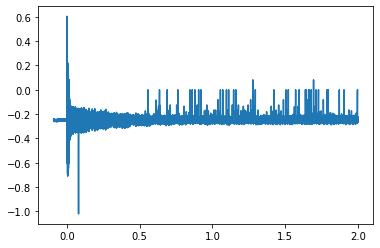

In [56]:
times, signals = get_signals_times_from_file(filename)
plt.plot(times, signals)

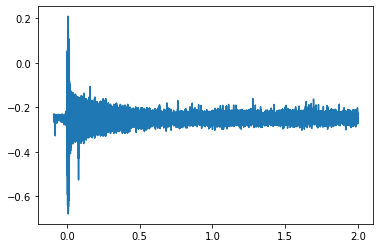

In [57]:
signals = fft_denoise(signals)
plt.plot(times, signals)

t0 = times[np.argmax(np.abs(signals))]
start = t0 + 0.1

In [58]:
t0

0.0092

Text(0, 0.5, 'signal (V)')

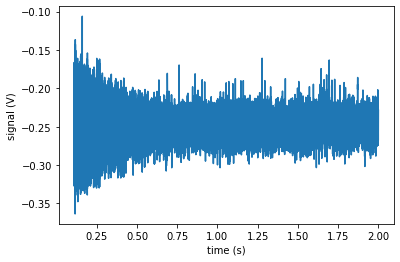

In [59]:
rang = np.where(times >= start)
times = times[rang]
signals = signals[rang]

plt.plot(times, signals)
plt.xlabel('time (s)')
plt.ylabel('signal (V)')
# plt.savefig('signal1.png')

Text(0, 0.5, 'absolute value of FFT signal (V)')

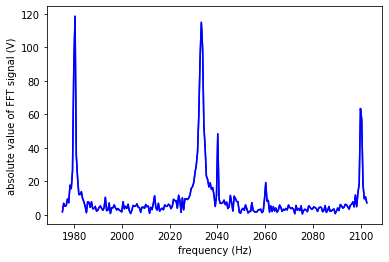

In [60]:
dt = np.average(np.diff(times))
N = len(times)
yf = fft(signals)
xf = fftfreq(N, dt)

# where_to_delete = np.logical_or((1975 <= xf)*(xf <= 1985),
#                                 (2095 <= xf)*(xf <= 2103))

# yf[where_to_delete] = 0.

mask = np.where((1975. <= xf)*(xf <= 2103.))
plt.plot(xf[mask], np.abs(yf[mask]), linestyle='-', color='blue')
freq = xf[mask][np.argmax(np.abs(yf[mask]))]

plt.plot(xf[mask], np.abs(yf[mask]), linestyle='-', color='blue')
plt.xlabel('frequency (Hz)')
plt.ylabel('absolute value of FFT signal (V)')
# plt.savefig('fft.png')

In [61]:
freq

1980.4336329984135

Text(0, 0.5, 'signal (V)')

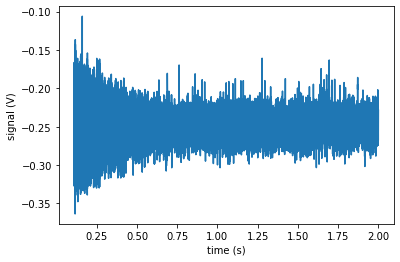

In [62]:
filtered_signal = ifft(yf)
plt.plot(times, np.real(filtered_signal))
plt.xlabel('time (s)')
plt.ylabel('signal (V)')

[1.44870657e-04 9.60793859e-03 3.36049322e-21]
(0+/-8)e+05


Text(0, 0.5, 'signal (V)')

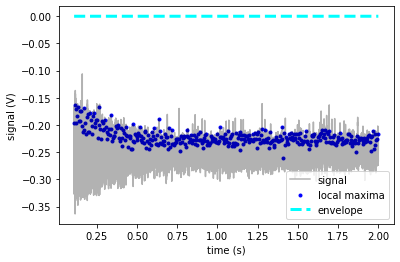

In [63]:
def local_max_filter(times, signals):
    condition = np.where((signals[:-2] < signals[1:-1]) & (signals[1:-1] > signals[2:]))[0] + 1
    return times[condition], signals[condition]

envelope_times = np.copy(times)
envelopes = np.copy(signals)
for i in range(1):
    envelope_times, envelopes = local_max_filter(envelope_times, envelopes)

plt.plot(times, signals, alpha = 0.3, color = 'black', label = 'signal')
plt.scatter(envelope_times[::10], envelopes[::10], color = 'blue', alpha = 1, marker = '.', label = 'local maxima')

func = lambda t, a, T2, c: a * np.exp(-t/T2) + c
popt, pcov = curve_fit(func, envelope_times, envelopes, bounds = (0, 10))
plt.plot(envelope_times, func(envelope_times, *popt), color = 'cyan',linestyle = '--' , linewidth = 3, label = 'envelope')
print(popt)
print(ufloat(popt[1], np.sqrt(pcov[1,1])))

plt.legend()
plt.xlabel('time (s)')
plt.ylabel('signal (V)')
# plt.savefig('signal2.png')

$y=a\exp(-(t-t_0)/T_2) + c$

In [64]:
freqs = []
T2s = []

def get_T2_relaxation(polar_time):
    filename = 'polar_time/' + f'{polar_time:.1f}'.replace('.','_')+'.csv'
    times, signals = get_signals_times_from_file(filename)

    signals = fft_denoise(signals)

    t0 = times[np.argmax(np.abs(signals))]
    start = t0 + 0.1
    rang = np.where(times >= start)
    times = times[rang]
    signals = signals[rang]

    # FFT
    freq = get_freq(times, signals)
    freqs.append(freq)
    # FFT end

    envelope_times = np.copy(times)
    envelopes = np.copy(signals)
    for i in range(1):
        envelope_times, envelopes = local_max_filter(envelope_times, envelopes)

    # plt.plot(times, signals)
    # plt.plot(envelope_times, envelopes, color = 'red')

    func = lambda t, a, T2, c: a * np.exp(-(t-t0)/T2) + c
    popt, pcov = curve_fit(func, envelope_times, envelopes, bounds = (0, 10))
    # plt.plot(envelope_times, func(envelope_times, *popt), color = 'green')
    result = dict(zip(['a', 'T2', 'c'], popt))
    T2s.append(popt[1])
    return result

In [65]:
# polar_times = np.arange(1.5, 10.5, 0.5)
# initial_amplitudes = []
# for polar_time in polar_times:
#     filename = 'polar_time/' + f'{polar_time:.1f}'.replace('.','_')+'.csv'
#     times, signals = get_signals_times_from_file(filename)
#     # initial_amplitude = (signals[np.where((times >= 0.))])
#     savefig(f'{polar_time}.png', signals, times, -1, 2.)

ValueError: attempt to get argmax of an empty sequence

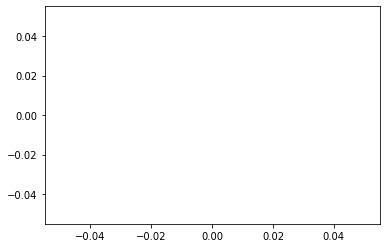

In [66]:
polar_times = np.delete(np.arange(1.5, 10.5, 0.5),6)
init_amps = []
for polar_time in polar_times:
    init_amps.append(get_T2_relaxation(polar_time)['a'])

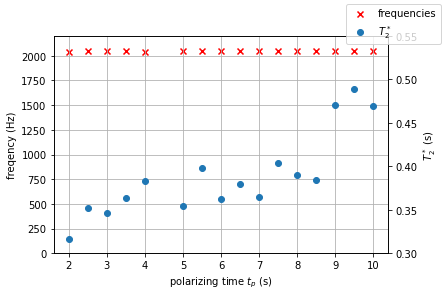

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

s1 = ax1.scatter(polar_times[1:], freqs[1:], marker = 'x', color = 'red',label='frequencies')
ax1.set_ylabel('freqency (Hz)')
ax1.set_ylim(0,2200)
ax2.set_ylabel(r'$T_2^*$ (s)')
ax2.set_ylim(0.3, 0.55)

s2 = ax2.scatter(polar_times[1:], T2s[1:], label=r'$T_2^*$')
ax1.grid()
ax1.set_xlabel(r'polarizing time $t_p$ (s)')

fig.legend()

# fig.savefig('polar_times.png')

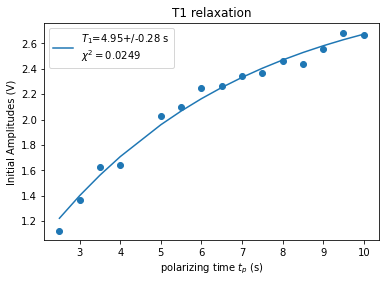

In [ ]:
polar_times = polar_times[1:]
init_amps = init_amps[1:]

plt.scatter(polar_times, init_amps)

T1_relaxation = lambda t, a, T1 : a*(1-np.exp(-t/T1))

popt, pcov = curve_fit(T1_relaxation, polar_times, init_amps, bounds = (0,np.inf))
fit_init_amps =  T1_relaxation(polar_times, *popt)
chisq = np.sum((init_amps - fit_init_amps) ** 2 / fit_init_amps)
plt.plot(polar_times, fit_init_amps, label = rf'$T_1$={ufloat(popt[1],np.sqrt(pcov[1,1]))} s ' + '\n' + f'$\chi^2={chisq:.4f}$')
plt.legend()
plt.title('T1 relaxation')
plt.xlabel(r'polarizing time $t_p$ (s)')
plt.ylabel('Initial Amplitudes (V)')

# plt.savefig('T1_relaxation.png')

5.342236529246845+/-0.37691812210429754